# Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time
from tensorflow import keras as keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
stock = 'aapl' # Apple

df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', axis=1, inplace=True)
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


In [3]:
# Add columns for offsets
df['t+1'] = np.r_[df['Close'].values[1:], np.nan]
df['t+5'] = np.r_[df['Close'].values[5:], np.empty((5,))*np.nan]
df['t+30'] = np.r_[df['Close'].values[30:], np.empty((30,))*np.nan]
df.head()

,Open,High,Low,Close,Volume,t+1,t+5,t+30
Date,,,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0.42134,0.44566,0.40853
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0.42902,0.45718,0.40593
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0.41618,0.44052,0.41491
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0.43927,0.43157,0.41874
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0.44566,0.43286,0.40339


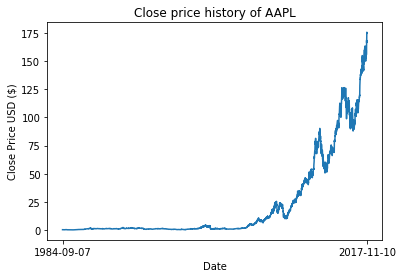

In [4]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

# Functions

In [5]:
# Set styles
# sb.set_style("darkgrid")
# plt.style.use("dark_background")

In [6]:
# Prepare data for autoregression with given timestep and offset (t+1/5/30)
# x has shape (num_samples, timestep)
def prepare_autoreg(data, timestep, offset):
    x,y = [],[]
    for i in range(timestep,len(data)):
        if i+offset-1 < len(data):
            x.append(data[i-timestep:i])
            y.append(data[i+offset-1])
        else:
            break
    return np.array(x), np.array(y)

In [7]:
def train_val_test_split(data, timestep, split=[0.6,0.2], offset=1, scaled=False, stationary=False):
    
    # Split train, validation & test data
    length = len(data)+1 if stationary else len(data)
    train_split = int(length * split[0]) + (-1 if stationary else 0)
    val_split = int(length * (split[0]+split[1])) + (-1 if stationary else 0)
    train_data = data[ : train_split] 
    val_data = data[train_split-timestep-offset+1 : val_split] 
    test_data = data[val_split-timestep-offset+1 : ]

    # Normalization if needed
    scaler = None
    if scaled:  
        scaler = MinMaxScaler(feature_range=(0,1))
        train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
        val_data = scaler.transform(np.array(val_data).reshape(-1,1))
        test_data = scaler.transform(np.array(test_data).reshape(-1,1))
        
    # Generate training and test dataset
    xtr, ytr = prepare_autoreg(train_data, timestep, offset)
    xval, yval = prepare_autoreg(val_data, timestep, offset)
    xts, yts = prepare_autoreg(test_data, timestep, offset)

    return (xtr, ytr, xval, yval, xts, yts), scaler

In [8]:
def build_lstm(timestep, nodes):
    lstm = Sequential()
    lstm.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,1)))
    lstm.add(LSTM(nodes))
    lstm.add(Dense(nodes))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm

In [9]:
def evaluate_lstm(data, model, scaler, **kwargs):
    
    # Define variables from arguments
    (xtr, ytr, xval, yval, xts, yts) = data
    show_loss = kwargs['show_loss'] if 'show_loss' in kwargs else 1 # show loss over epochs plot
    show_plot = kwargs['show_plot'] if 'show_plot' in kwargs else 1 # show time series plot
    stationary = kwargs['stationary'] if 'stationary' in kwargs else False # not stationary data by default
    
    # Check for missing args
    check_args = [k for k in ['actual_data','timestep','offset'] if k not in kwargs]
    if (show_plot or stationary) and len(check_args):
        raise Exception('The followings arguments are missing: %s' % ', '.join(check_args))
        return
    if show_loss and 'hist' not in kwargs:
        raise Exception('Please provide the model history handle (hist=handle) for plotting loss.')
        return
        
    # Prediction
    ytr_pred = model.predict(xtr)
    yval_pred = model.predict(xval)
    yts_pred = model.predict(xts)

    # Inverse transform all y values
    ytr_pred_itf = np.ravel(scaler.inverse_transform(ytr_pred))
    yval_pred_itf = np.ravel(scaler.inverse_transform(yval_pred))
    yts_pred_itf = np.ravel(scaler.inverse_transform(yts_pred))
    ytr_true = np.ravel(scaler.inverse_transform(ytr))
    yval_true = np.ravel(scaler.inverse_transform(yval))
    yts_true = np.ravel(scaler.inverse_transform(yts))
    
    # For stationary data, perform necessary inverse transformation
    if stationary:
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        str_end = timestep+offset-2 + len(ytr_pred_itf) + 1
        sval_end = str_end + len(yval_pred_itf)
        true_data = actual_data['Close'].values
        ytr_pred_itf = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_pred_itf]
        yval_pred_itf = true_data[str_end : sval_end] + yval_pred_itf
        yts_pred_itf = true_data[sval_end : -1] + yts_pred_itf
        ytr_true = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_true]
        yval_true = true_data[str_end : sval_end] + yval_true
        yts_true = true_data[sval_end : -1] + yts_true

    # Get RMSE
    rmse_tr = mean_squared_error(ytr_true, ytr_pred_itf, squared=False)
    rmse_val = mean_squared_error(yval_true, yval_pred_itf, squared=False)
    rmse_ts = mean_squared_error(yts_true, yts_pred_itf, squared=False)

    # Visualize loss
    if show_loss:
        hist = kwargs['hist']
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training', 'Validation'])
        plt.xlabel('Epochs')
        plt.title('Loss (MSE) over Epochs')
        plt.show()
        print('RMSE (Train):', rmse_tr)
        print('RMSE (Val):', rmse_val)

    # Visualize data
    if show_plot:
        # Define variables
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        title = kwargs['title'] if 'title' in kwargs else 'Predicted Close Values'
        suffix = ' (%s)' % kwargs['stock'].upper() if 'stock' in kwargs else ''
        save_fig = kwargs['save_fig'] if 'save_fig' in kwargs else False
        
        # Define params
        dates = actual_data.index.values
        ytr_end = ytr_pred_itf.shape[0] + timestep + offset-1
        yval_end = yval_pred_itf.shape[0] + ytr_end
    
        # Plot
        plt.figure(figsize=(8,5))
        plt.plot(actual_data['Close'], label='Actual')
        plt.plot(dates[timestep+offset-1:ytr_end], ytr_pred_itf, label='Pred (Train)\nRMSE = %.3f' % rmse_tr)
        plt.plot(dates[ytr_end:yval_end], yval_pred_itf, label='Pred (Val)\nRMSE = %.3f' % rmse_val)
        plt.plot(dates[yval_end:], yts_pred_itf, label='Pred (Test)\nRMSE = %.3f' % rmse_ts)
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.xticks([list(dates)[0], list(dates)[-1]])
        plt.title(title + suffix)
        plt.legend()
        if save_fig:
            plt.savefig(save_fig, transparent=True);
        plt.show()
        
    return (rmse_tr, rmse_val, rmse_ts), (ytr_pred_itf, yval_pred_itf, yts_pred_itf)

# Regression Models for Diff Time Periods

## Defining Tuned Hyperparameters

In [10]:
step = 55
node = 45
epoch = 40
bsize = 32
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # global callback for all models
stock_data = df['Close'].values # create new df with only 'Close' column

## Next Day Prediction

In [11]:
# Generate train/val/test split
data_dd, scaler_dd = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=1, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_dd
print(xtr.shape, ytr.shape)
print(xval.shape, yval.shape)
print(xts.shape, yts.shape)

# Build LSTM model
lstm_dd = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_dd = lstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

(5799, 55, 1) (5799, 1)
(837, 55, 1) (837, 1)
(1673, 55, 1) (1673, 1)
Training... Done. Time taken: 46.208s


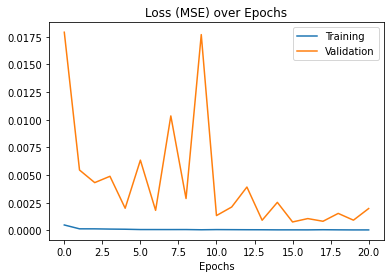

RMSE (Train): 0.42374580703621745
RMSE (Val): 1.0801756773980646


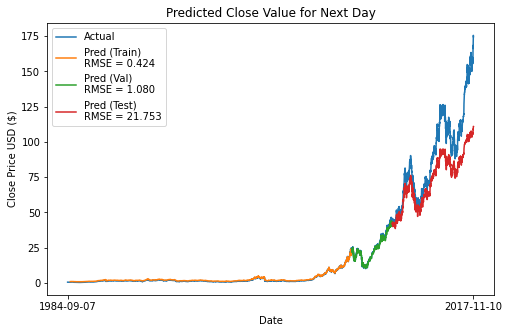

In [12]:
rmse_dd, pred_dd = evaluate_lstm(data_dd, lstm_dd, scaler_dd,
                                 hist=hist_dd, title='Predicted Close Value for Next Day',
                                 actual_data=df, timestep=step, offset=1);

## Next Week Prediction

In [13]:
# Generate train/val/test split
data_wk, scaler_wk = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=5, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_wk

# Build LSTM model
lstm_wk = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_wk = lstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 35.271s


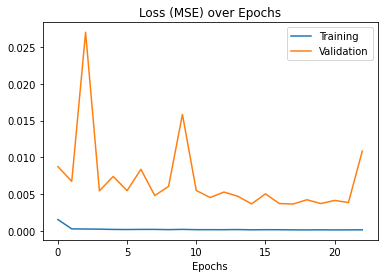

RMSE (Train): 0.2521136839213201
RMSE (Val): 2.5351592305455526


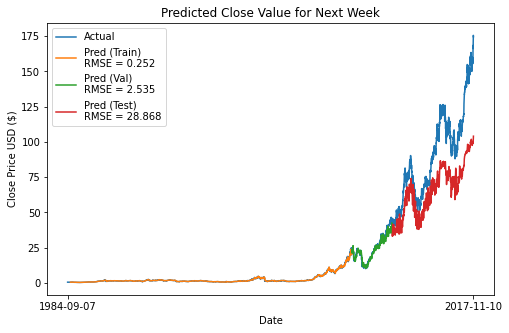

In [14]:
rmse_wk, pred_wk = evaluate_lstm(data_wk, lstm_wk, scaler_wk, 
                                 hist=hist_wk, title='Predicted Close Value for Next Week',
                                 actual_data=df, timestep=step, offset=5, save_fig='wk_norm');

## Next Month Prediction

In [15]:
# Generate train/val/test split
data_mm, scaler_mm = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=30, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_mm

# Build LSTM model
lstm_mm = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_mm = lstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 15.739s


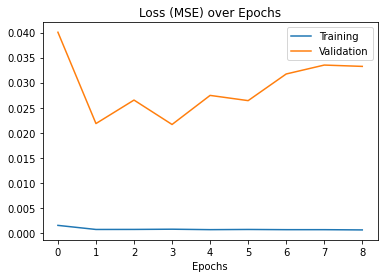

RMSE (Train): 0.5532728875668916
RMSE (Val): 4.436212512546086


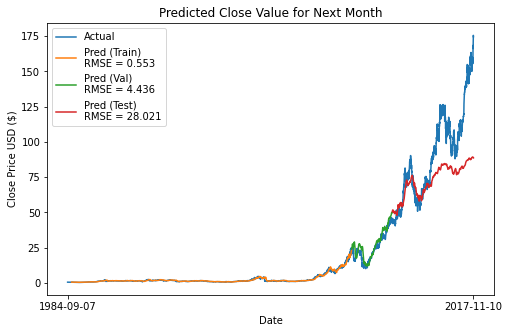

In [16]:
rmse_mm, pred_mm = evaluate_lstm(data_mm, lstm_mm, scaler_mm,
                                 hist=hist_mm, title='Predicted Close Value for Next Month',
                                 actual_data=df, timestep=step, offset=30, save_fig='mm_norm');

## Comparison

In [17]:
compare_df_dict = {
    'Offset': ['t+1', 't+5', 't+30'],
    'RMSE (Train)': [rmse_dd[0], rmse_wk[0], rmse_mm[0]],
    'RMSE (Val)': [rmse_dd[1], rmse_wk[1], rmse_mm[1]],
    'RMSE (Test)': [rmse_dd[2], rmse_wk[2], rmse_mm[2]]
}
compare_df = pd.DataFrame(compare_df_dict)
compare_df.set_index('Offset', inplace=True)
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test)
Offset,,,
t+1,0.423746,1.080176,21.752826
t+5,0.252114,2.535159,28.867959
t+30,0.553273,4.436213,28.021301


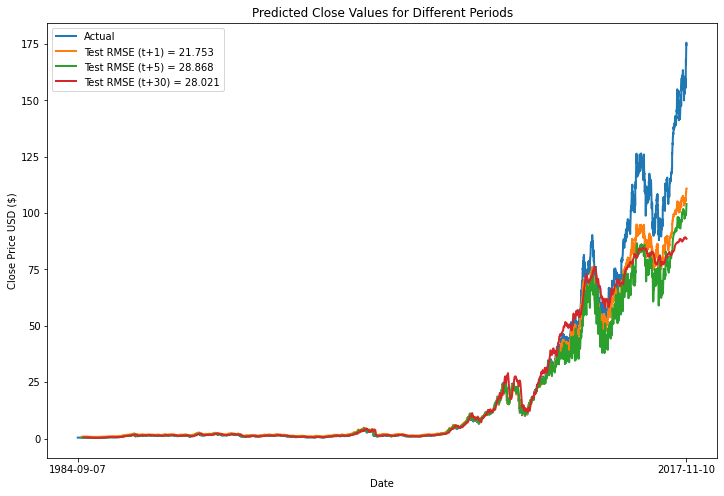

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df['Close'], linewidth=2, label='Actual')
plt.plot(df.index.values[step:], np.r_[pred_dd[0],pred_dd[1],pred_dd[2]], linewidth=2, label='Test RMSE (t+1) = %.3f' % rmse_dd[2])
plt.plot(df.index.values[step+4:], np.r_[pred_wk[0],pred_wk[1],pred_wk[2]], linewidth=2, label='Test RMSE (t+5) = %.3f' % rmse_wk[2])
plt.plot(df.index.values[step+29:], np.r_[pred_mm[0],pred_mm[1],pred_mm[2]], linewidth=2, label='Test RMSE (t+30) = %.3f' % rmse_mm[2])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.title('Predicted Close Values for Different Periods')
plt.legend()
# plt.savefig('compare', transparent=True)
plt.show()

# Regression Model for Diff Time Periods (Stationary)

In [19]:
stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality

## Next Day Prediction (Stationary)

In [20]:
# Generate train/val/test split
sdata_dd, sscaler_dd = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=1, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_dd
print(xtr.shape, ytr.shape)
print(xval.shape, yval.shape)
print(xts.shape, yts.shape)

# Build LSTM model
slstm_dd = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_dd = slstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

(4962, 55, 1) (4962, 1)
(1673, 55, 1) (1673, 1)
(1673, 55, 1) (1673, 1)
Training... Done. Time taken: 36.378s


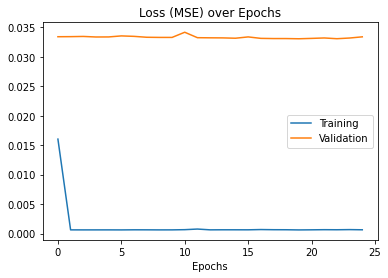

RMSE (Train): 0.06175839741016726
RMSE (Val): 0.4162345718234906


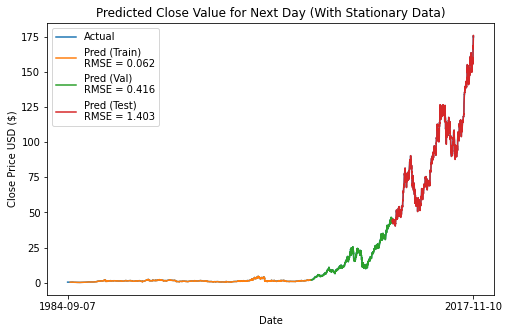

In [21]:
srmse_dd, spred_dd = evaluate_lstm(sdata_dd, slstm_dd, sscaler_dd, stationary=True,
                                   hist=shist_dd, title='Predicted Close Value for Next Day (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=1);

## Next Week Prediction (Stationary)

In [22]:
# Generate train/val/test split
sdata_wk, sscaler_wk = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=5, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_wk

# Build LSTM model
slstm_wk = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_wk = slstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 56.783s


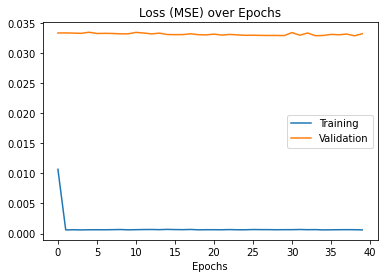

RMSE (Train): 0.0592769128888678
RMSE (Val): 0.41517998116148225


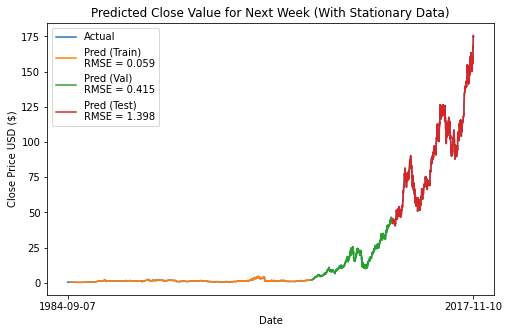

In [23]:
srmse_wk, spred_wk = evaluate_lstm(sdata_wk, slstm_wk, sscaler_wk, stationary=True,
                                  hist=shist_wk, title='Predicted Close Value for Next Week (With Stationary Data)',
                                  actual_data=df, timestep=step, offset=5);

## Next Month Prediction (Stationary)

In [24]:
# Generate train/val/test split
sdata_mm, sscaler_mm = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=30, scaled=True, stationary=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_mm

# Build LSTM model
slstm_mm = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_mm = slstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 54.930s


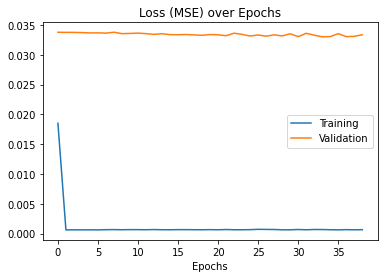

RMSE (Train): 0.06091400631979878
RMSE (Val): 0.41611433358735783


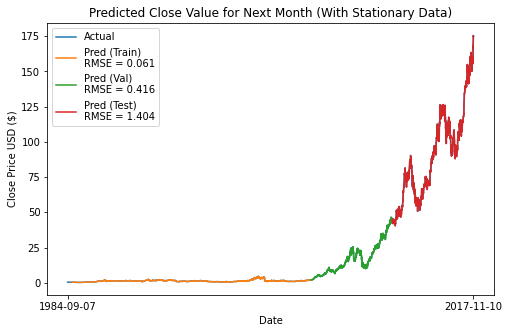

In [25]:
srmse_mm, spred_mm = evaluate_lstm(sdata_mm, slstm_mm, sscaler_mm, stationary=True,
                                   hist=shist_mm, title='Predicted Close Value for Next Month (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=30);

## Comparison (With Models trained on Stationary Data)

In [26]:
compare_df['RMSE (Train/Stat)'] = [srmse_dd[0], srmse_wk[0], srmse_mm[0]]
compare_df['RMSE (Val/Stat)'] = [srmse_dd[1], srmse_wk[1], srmse_mm[1]]
compare_df['RMSE (Test/Stat)'] = [srmse_dd[2], srmse_wk[2], srmse_mm[2]]
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.423746,1.080176,21.752826,0.061758,0.416235,1.402904
t+5,0.252114,2.535159,28.867959,0.059277,0.415180,1.398372
t+30,0.553273,4.436213,28.021301,0.060914,0.416114,1.404017


# Prediction of Trend

In [27]:
def classify(df, pred, offset):
    test_len = len(pred)
    diff = (df['t+%d'%offset].values - df['Close'].values)[-test_len-offset:-offset]
    actual_trend = np.where(diff>0, 1, 0)
    pred_trend = np.where(pred - df['Close'].values[-test_len-offset:-offset]>0, 1, 0)
    total_mg = (diff @ actual_trend)
    total_eg = (diff @ pred_trend)
    mg = total_mg / list(actual_trend).count(1)
    eg = total_eg/list(pred_trend).count(1) if list(pred_trend).count(1)>0 else 0
    return (actual_trend, pred_trend), (eg, mg), (total_eg, total_mg)

In [28]:
preds = [pred_dd, pred_wk, pred_mm, spred_dd, spred_wk, spred_mm]
trend_true, trend_pred = [[] for k in range(6)], [[] for k in range(6)]
gains, total_gains = [[] for k in range(6)], [[] for k in range(6)]

# ×6 for dd,wk,mm for normal and stationary data
for i in range(6): 
    offset = [1,5,30][i%3]
    trends, gain, total_gain = classify(df, preds[i][2], offset)
    trend_true[i], trend_pred[i] = trends[0], trends[1]
    gains[i] = gain
    total_gains[i] = total_gain
    
metrics_dict = {
    'Accuracy':[],
    'Precision':[],
    'Recall':[],
    'F1 Score':[]
} 

print('Confusion Matrices for each Model:')
for i in range(6):
    metrics_dict['Accuracy'].append(accuracy_score(trend_true[i], trend_pred[i]))
    metrics_dict['Precision'].append(precision_score(trend_true[i], trend_pred[i], zero_division=0))
    metrics_dict['Recall'].append(recall_score(trend_true[i], trend_pred[i], zero_division=0))
    metrics_dict['F1 Score'].append(f1_score(trend_true[i], trend_pred[i]))
    tn, fp, fn, tp = confusion_matrix(trend_true[i], trend_pred[i]).ravel()
    cmat = pd.DataFrame({'':['Pred Up','Pred Down'], 'Actual Up':[tp,fn], 'Actual Down':[fp,tn]})
    cmat.set_index('', inplace=True)
    print(['Day:','\nWeek:','\nMonth:', 'Day (Stat):','\nWeek (Stat):','\nMonth (Stat):'][i])
    display(cmat)

Confusion Matrices for each Model:
Day:


,Actual Up,Actual Down
,,
Pred Up,0,0
Pred Down,869,804



Week:


,Actual Up,Actual Down
,,
Pred Up,0,0
Pred Down,934,739



Month:


,Actual Up,Actual Down
,,
Pred Up,278,185
Pred Down,728,482


Day (Stat):


,Actual Up,Actual Down
,,
Pred Up,405,346
Pred Down,464,458



Week (Stat):


,Actual Up,Actual Down
,,
Pred Up,821,105
Pred Down,113,634



Month (Stat):


,Actual Up,Actual Down
,,
Pred Up,960,35
Pred Down,46,632


In [29]:
metric_df = pd.DataFrame({k:v[:3] for k,v in metrics_dict.items()})
metric_df['Offset'] = compare_df.index.values
metric_df.set_index('Offset', inplace=True)
for metric in metrics_dict:
    metric_df[metric+' (Stat)'] = metrics_dict[metric][3:]
display(compare_df)
display(metric_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.423746,1.080176,21.752826,0.061758,0.416235,1.402904
t+5,0.252114,2.535159,28.867959,0.059277,0.415180,1.398372
t+30,0.553273,4.436213,28.021301,0.060914,0.416114,1.404017


,Accuracy,Precision,Recall,F1 Score,Accuracy (Stat),Precision (Stat),Recall (Stat),F1 Score (Stat)
Offset,,,,,,,,
t+1,0.480574,0.000000,0.000000,0.000000,0.515840,0.539281,0.466053,0.500000
t+5,0.441721,0.000000,0.000000,0.000000,0.869695,0.886609,0.879015,0.882796
t+30,0.454274,0.600432,0.276342,0.378489,0.951584,0.964824,0.954274,0.959520


# Expected Gain

In [30]:
for i in range(3):
    print('Expected Gain per ' + ['Day:','Week:','Month:'][i], end=' ')
    print('%.3g, %.3f (Stationary)' % (gains[i][0], gains[i+3][0]))
print()    
for i in range(3):
    print('Max Gain per ' + ['Day:','Week:','Month:'][i], end=' ')
    print('%.3f' % gains[i][1])
print()
for i in range(3):
    pgain = total_gains[i+3][0]/total_gains[i+3][1]
    print('% Gain per ' + ['Day:','Week:','Month:'][i], end=' ')
    print('%.2f' % (pgain*100) + "%", end=' ')
    print('(%.2f/%.2f)' % (total_gains[i+3][0],total_gains[i+3][1]))

Expected Gain per Day: 0, 0.114 (Stationary)
Expected Gain per Week: 0, 2.295 (Stationary)
Expected Gain per Month: 2.11, 7.050 (Stationary)

Max Gain per Day: 1.017
Max Gain per Week: 2.488
Max Gain per Month: 7.051

% Gain per Day: 9.71% (85.81/883.89)
% Gain per Week: 91.44% (2125.14/2324.10)
% Gain per Month: 98.89% (7014.79/7093.55)


# Different Stocks

In [31]:
# up_stocks = ['aapl','ibm'] # upward trends
# both_stocks = ['xhr','mik'] # bi-directional trends
# down_stocks = ['sypr','ypf'] # downward trends
up_stocks, both_stocks, down_stocks = ['aapl'], ['mik'], ['ypf']
z = 30 # best offset

In [32]:
def train_diff_stocks(z):
    diff_stocks = {'vars':{},'model':{},'rmse':{},'acc':{},'rec':{},'prc':{},'f1':{},'gain':{},'max_gain':{},'pgain':{}}
    
    for stock in up_stocks+both_stocks+down_stocks:

        # Import stock data
        df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
        stock_data = df['Close'].values
        stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality

        # Generate dataset
        data, scaler = train_val_test_split(stock_data, step, split=[0.6,0.2], offset=z, scaled=True)
        sdata, sscaler = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=z, scaled=True, stationary=True)
        (xtr, ytr, xval, yval, xts, yts) = sdata

        # Training, prediction, evaluation
        lstm = build_lstm(timestep=step, nodes=node)
        start = time.time()
        print('Training (%s)...' % stock, end=' ')
        lstm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
        end = time.time()
        print('Done. Time taken: %.3fs' % (end-start))

        diff_stocks['vars'][stock] = (df, data, scaler, sdata, sscaler)
        diff_stocks['model'][stock] = lstm
        
    return diff_stocks

In [33]:
def evaluate_diff_stocks(diff_stocks, stocks, offset, show_plot=1, save_fig=False):
    for stock in stocks:
        df = diff_stocks['vars'][stock][0]
        data, scaler = diff_stocks['vars'][stock][1], diff_stocks['vars'][stock][2]
        sdata, sscaler = diff_stocks['vars'][stock][3], diff_stocks['vars'][stock][4]
        model = diff_stocks['model'][stock]
        
        # Add columns for offsets
        df['t+1'] = np.r_[df['Close'].values[1:], np.nan]
        df['t+5'] = np.r_[df['Close'].values[5:], np.empty((5,))*np.nan]
        df['t+30'] = np.r_[df['Close'].values[30:], np.empty((30,))*np.nan]
        
        # Get RMSE and Predicted Values
        rmse, pred = evaluate_lstm(sdata, model, sscaler, stationary=True,
                                   show_loss=0, show_plot=show_plot, title='Predicted Close Values for Next Month',
                                   actual_data=df, timestep=step, offset=offset, stock=stock, save_fig=save_fig);
        
        # Find Accuracy, Precision, Recall, F1, Expected Gain
        trends, gain, total_gain = classify(df, pred[2], offset)
        trend_true, trend_pred = trends[0], trends[1]

        # Store Metrics
        diff_stocks['rmse'][stock] = [v for v in rmse]
        diff_stocks['acc'][stock] = accuracy_score(trend_true, trend_pred)
        diff_stocks['prc'][stock] = precision_score(trend_true, trend_pred, zero_division=0)
        diff_stocks['rec'][stock] = recall_score(trend_true, trend_pred, zero_division=0)
        diff_stocks['f1'][stock] = f1_score(trend_true, trend_pred)
        diff_stocks['pgain'][stock] = total_gain[0]/total_gain[1]
        diff_stocks['gain'][stock] = gain[0]
        diff_stocks['max_gain'][stock] = gain[1]
    
    return diff_stocks

In [34]:
def compare_diff_stocks(diff_stocks):
#     print('Compare metrics for different stocks:')
    compare_diff_stocks_dict = {
        'Stock': diff_stocks['model'].keys(),
        'RMSE (Train)': np.array(list(diff_stocks['rmse'].values()))[:,0],
        'RMSE (Val)': np.array(list(diff_stocks['rmse'].values()))[:,1],
        'RMSE (Test)': np.array(list(diff_stocks['rmse'].values()))[:,2],
        'Accuracy': diff_stocks['acc'].values(),
        'Precision': diff_stocks['prc'].values(),
        'Recall': diff_stocks['rec'].values(),
        'F1 Score': diff_stocks['f1'].values(),
        '% Expected Gain': diff_stocks['pgain'].values(),
        'Expected Gain': diff_stocks['gain'].values(),
        'Max Gain': diff_stocks['max_gain'].values()
    }
    compare_diff_stocks_df = pd.DataFrame(compare_diff_stocks_dict)
    compare_diff_stocks_df.set_index('Stock', inplace=True)
    display(compare_diff_stocks_df)

## t+30

In [35]:
diff30 = train_diff_stocks(30)

Training (aapl)... Done. Time taken: 57.234s
Training (mik)... Done. Time taken: 4.059s
Training (ypf)... Done. Time taken: 10.159s


INCREASING


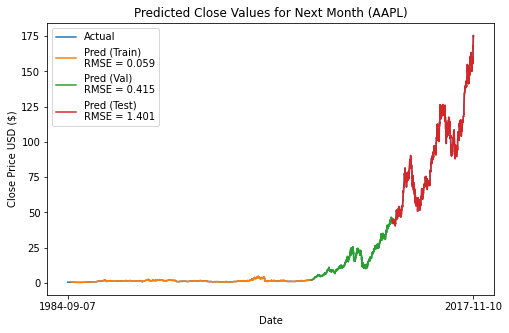

UP & DOWN


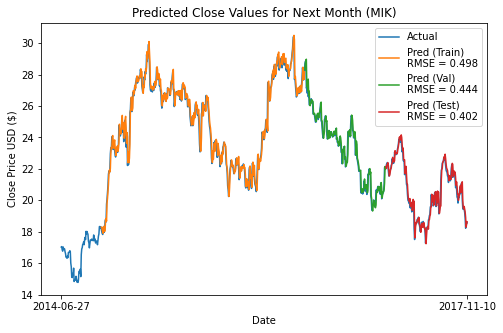

DOWN


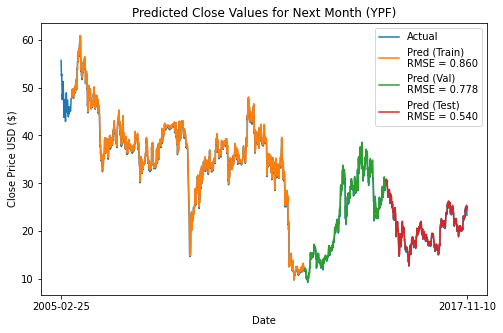

In [36]:
print('INCREASING')
diff30 = evaluate_diff_stocks(diff30, ['aapl'], offset=30) # save_fig='aapl'
print('UP & DOWN')
diff30 = evaluate_diff_stocks(diff30, ['mik'], offset=30) # save_fig='mik'
print('DOWN')
diff30 = evaluate_diff_stocks(diff30, ['ypf'], offset=30) # save_fig='ypf'

In [37]:
compare_diff_stocks(diff30)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.058708,0.415229,1.401236,0.951584,0.964824,0.954274,0.959520,0.988940,7.050347,7.051241
mik,0.498208,0.444131,0.402048,0.994152,0.989691,1.000000,0.994819,0.998178,1.863918,1.886771
ypf,0.860135,0.777975,0.540342,0.954688,0.937063,0.960573,0.948673,0.989125,2.367713,2.453803


## t+1

In [38]:
diff1 = train_diff_stocks(1)

Training (aapl)... Done. Time taken: 15.554s
Training (mik)... Done. Time taken: 6.511s
Training (ypf)... Done. Time taken: 9.223s


In [39]:
diff1 = evaluate_diff_stocks(diff1, ['aapl', 'mik', 'ypf'], offset=1, show_plot=0)
compare_diff_stocks(diff1)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.086813,0.423248,1.411246,0.521817,0.551880,0.422325,0.478488,0.095814,0.127352,1.017138
mik,0.493694,0.461659,0.405756,0.514620,0.517647,0.988764,0.679537,-0.167485,-0.022059,0.251573
ypf,0.825327,0.758270,0.489409,0.529687,0.500000,0.009967,0.019544,-0.002931,-0.054500,0.370615


## t+5

In [40]:
diff5 = train_diff_stocks(5)

Training (aapl)... Done. Time taken: 34.581s
Training (mik)... Done. Time taken: 6.145s
Training (ypf)... Done. Time taken: 16.900s


In [41]:
diff5 = evaluate_diff_stocks(diff5, ['aapl', 'mik', 'ypf'], offset=5, show_plot=0)
compare_diff_stocks(diff5)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.060200,0.416354,1.401513,0.866109,0.880086,0.880086,0.880086,0.912161,2.269760,2.488333
mik,0.523239,0.472299,0.418706,0.836257,0.893939,0.737500,0.808219,0.819331,0.667879,0.672500
ypf,0.842660,0.760485,0.517317,0.835938,0.757979,0.953177,0.844444,0.885077,0.627755,0.891920


In [42]:
compare_diff_stocks(diff1)
compare_diff_stocks(diff5)
compare_diff_stocks(diff30)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.086813,0.423248,1.411246,0.521817,0.551880,0.422325,0.478488,0.095814,0.127352,1.017138
mik,0.493694,0.461659,0.405756,0.514620,0.517647,0.988764,0.679537,-0.167485,-0.022059,0.251573
ypf,0.825327,0.758270,0.489409,0.529687,0.500000,0.009967,0.019544,-0.002931,-0.054500,0.370615


,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.060200,0.416354,1.401513,0.866109,0.880086,0.880086,0.880086,0.912161,2.269760,2.488333
mik,0.523239,0.472299,0.418706,0.836257,0.893939,0.737500,0.808219,0.819331,0.667879,0.672500
ypf,0.842660,0.760485,0.517317,0.835938,0.757979,0.953177,0.844444,0.885077,0.627755,0.891920


,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Expected Gain,Expected Gain,Max Gain
Stock,,,,,,,,,,
aapl,0.058708,0.415229,1.401236,0.951584,0.964824,0.954274,0.959520,0.988940,7.050347,7.051241
mik,0.498208,0.444131,0.402048,0.994152,0.989691,1.000000,0.994819,0.998178,1.863918,1.886771
ypf,0.860135,0.777975,0.540342,0.954688,0.937063,0.960573,0.948673,0.989125,2.367713,2.453803
